## CLASIFICADOR DE MENSAJES DE TEXTO (LSTM)

Este ejemplo se corresponde con un modelo de clasificación binaria para detectar qué mensajes de texto son spam o no spam (ham). Por otra parte, también se ha añadido una sección para predecir o detectar ham(correo auténtico) o spam, utilizando mensaje de texto que nunca hemos visto antes.

Se utiliza un conjunto de datos públicos de: UCL datasets. Contiene 5.574 mensajes de teléfono SMS. Los datos se recogieron con el fin de investigar el spam en la telefonía móvil. Los datos se han etiquetado como spam o no spam (ham).

Se trabaja con el clasificador denso, la memoria a largo plazo (LSTM), la memoria a largo plazo bidireccional (Bi-LSTM) y la unidad recurrente cerrada (GRU) como método y compararemos todos estos métodos en términos de rendimiento del modelo.

Aquí están los pasos para hacer el experimento:

1. Importar las librerías
2. Cargar el conjunto de datos
3. Visualizar los mensajes de spam o de spam utilizando wordcloud
4. Tratamiento de datos desequilibrados
5. Preprocesamiento del texto
6. Definir la arquitectura del modelo y entrenar los cuatro modelos
7. Comparación de los resultados de los cuatro modelos
8. Utilizar el modelo final entrenado para clasificar los nuevos mensajes

### IMPORTAMOS LIBRERÍAS

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

2024-05-17 13:14:26.789964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Carga del dataset

El conjunto de datos que se utiliza procede del *UCI Machine Learning Repository*: SMS Spam Collection Dataset.

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/kenneth-lee-ch/SMS-Spam-Classification/master/spam.csv', encoding='ISO-8859-1')
# rename the columns
df = df[['v1','v2']]
df.rename(columns={'v1':'label', 'v2':'message'}, inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

### Visualizar un mensaje de spam o de spam con WordCloud
Este paso consiste en visualizar las palabras que aparecen con más frecuencia en un texto determinado utilizando WordCloud.

A continuación, exploraremos los datos por grupos de etiquetas creando un WordCloud del tipo "HAM".    
En primer lugar, vamos a crear un marco de datos separado para los mensajes de spam y los de spam y los convertiremos en una matriz numpy para generar WordCloud.

In [9]:
# Get all the ham and spam emails
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

Aquí se genera la nube de palabras (WordCloud) correspondiente al tipo de mensajes "HAM"

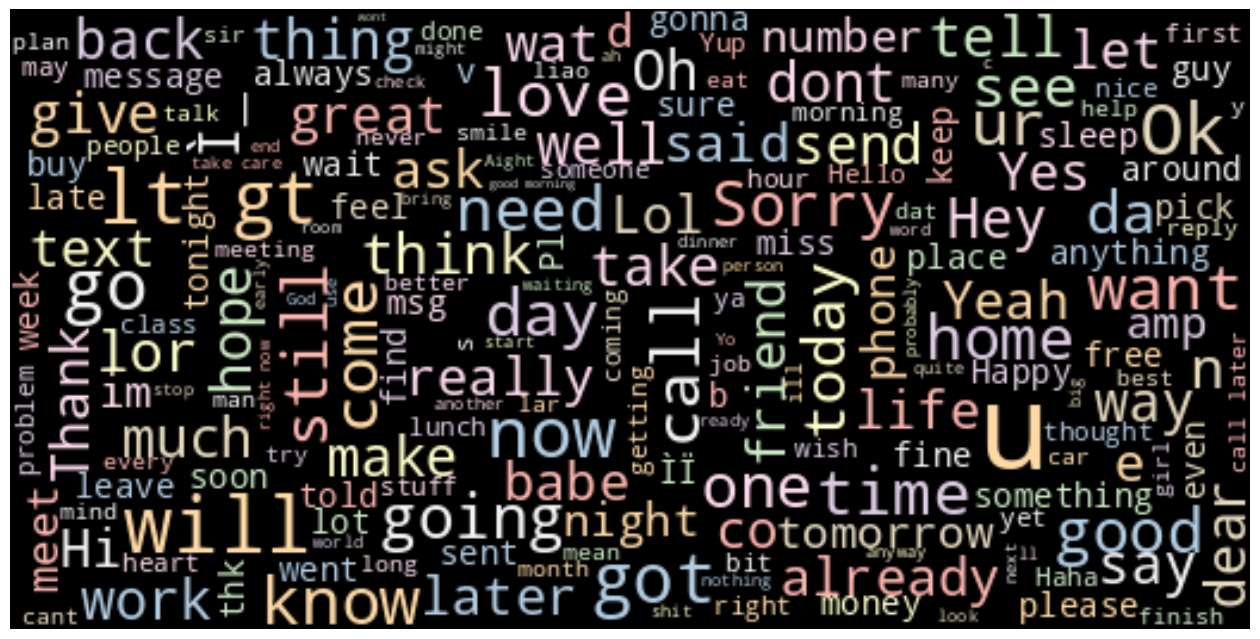

In [10]:
ham_msg_cloud = WordCloud(
                    width =520, 
                    height =260, 
                    stopwords = STOPWORDS, 
                    max_font_size = 50, 
                    background_color = "black", 
                    colormap = 'Pastel1').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

Las palabras que aparecen con más frecuencia en los mensajes de este tipo, según WordCloud, son: *now, will, ok, today, Sorry etc. (ahora, será, vale, hoy, lo siento, etc)*.   

La nube de palabras (WordCloud) para los mensajes de *spam* la generamos a continuación:

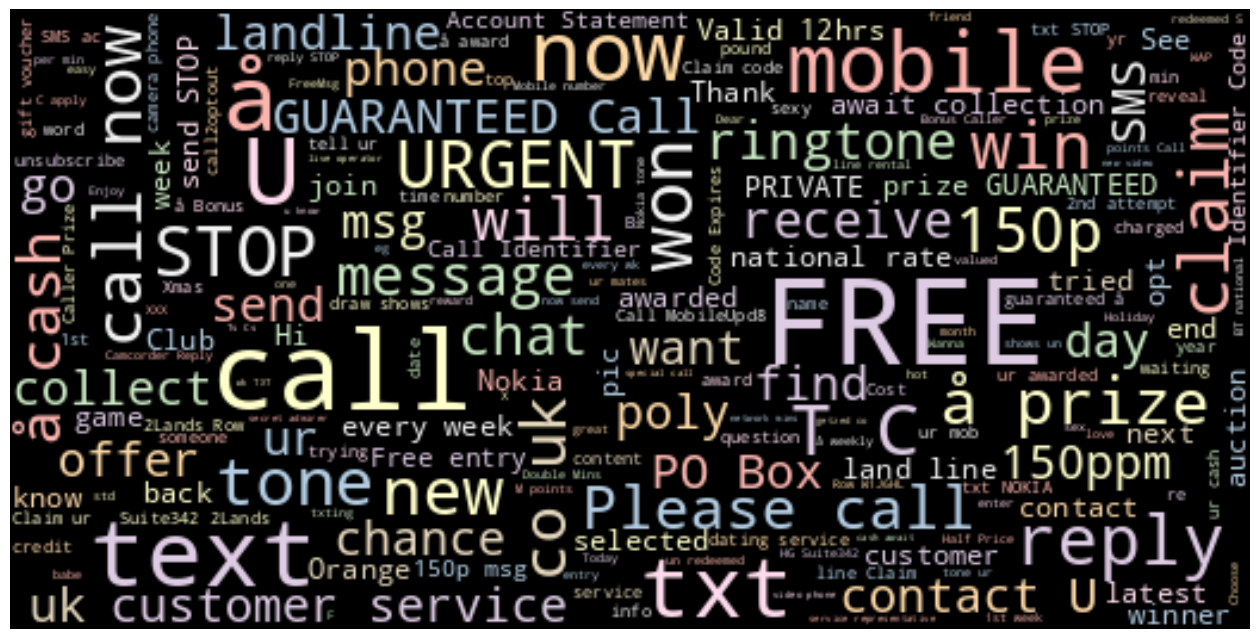

In [11]:
spam_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords=STOPWORDS,
                          max_font_size=50, 
                          background_color ="black",
                         colormap='Pastel1').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Para los mensajes de *spam*, las palabras que aparecen con más frecuencia en los mensajes son: *FREE, call, URGENT, mobile, etc. (GRATIS, llamada, URGENTE, móvil, etc)*.

### Tratamiento de los datos desbalanceados

Veamos cómo se distribuyen los mensajes *ham* y *spam*.

Text(0.5, 1.0, 'Distribución de los tipos de mensajes')

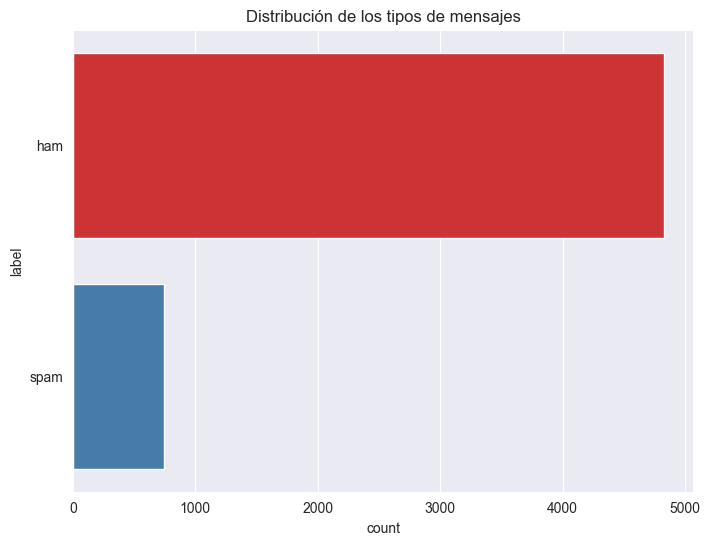

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(df.label,palette= "Set1")
plt.title('Distribución de los tipos de mensajes')
plt.ylabel("Tipo de mensaje")

A partir de la visualización de la distribución de datos anterior, se puede concluir que los datos están desbalanceados. Hay más mensajes de tipo HAM que de tipo SPAM.

Para tratar el problema del desbalanceado se pueden tomar alguna de las siguiente medidas:

- Elegir la métrica de evaluación adecuada
- Remuestreo (sobremuestreo y submuestreo)
- Técnica de sobremuestreo sintético de minorías (SMOTE)
- BalancedBaggingClassifier
- Umbral móvil

En este caso, se va a utilizar el método de submuestreo para tratar los datos desequilibrados. El submuestreo consiste en submuestrear la clase mayoritaria de forma aleatoria y uniforme. Esto puede provocar una pérdida de información, pero si los ejemplos de la clase mayoritaria están cerca de otros, este método puede dar buenos resultados.

In [17]:
# Downsample del tipo de mensajes ham 
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

In [23]:
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


Text(0, 0.5, 'Tipo de mensaje')

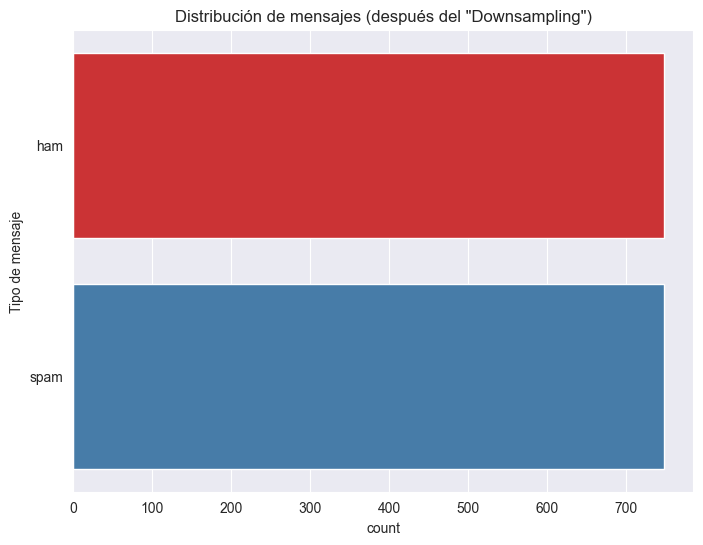

In [22]:
msg_df = ham_msg_df._append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label,palette= "Set1")
plt.title('Distribución de mensajes (después del "Downsampling")')
plt.ylabel('Tipo de mensaje')

## Preprocesamiento del texto

#### 1. Obtención de la columna longitud de cada texto y conversión de la etiqueta de texto en valor numérico.

Después de obtener un nuevo dataframe, añadimos la columna text_length (la longitud de cada mensaje de texto) y la columna msg_type (la etiqueta numérica convertida de los datos).

In [24]:
# Obtención de la longitud de columna para cada texto
msg_df['text_length'] = msg_df['message'].apply(len)

msg_df['msg_type'] = msg_df['label'].map({'ham':0, 'spam':1})
msg_label = msg_df['msg_type'].values
msg_df.head()

,label,message,text_length,msg_type
0,ham,"Yes, princess. Toledo.",22,0
1,ham,Dude while were makin those weirdy brownies my...,88,0
2,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",169,0
3,ham,Then u ask darren go n pick u lor... But i oso...,74,0
4,ham,Lol no. I just need to cash in my nitros. Hurr...,75,0


#### 2. División en conjuntos TRAIN/TEST.

A continuación, realizamos una división de train y test (80% de datos de entrenamiento y un 20% de datos de test).

In [25]:
x_train, x_test, y_train, y_test = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

#### 3. Tokenización
 Conversión del texto de los mensajes en datos numéricos, para que nuestro modelo pueda trabajar con ellos.

In [26]:
# Definición de los parámetros de pre-procesado
max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

Este proceso realizará todos los pasos de preprocesamiento necesarios:

- Tokenizar a nivel de palabra.
- Se usa el parámetro *num_words* para determinar el número máximo de tokens únicos
- Filtrar los términos de puntuación
- Convertir todas las palabras a minúsculas
- Convertir todas las palabras a índices de tipo entero.

In [27]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

En el código anterior tenemos los siguientes parámetros:   
- **num_words**: número de palabras únicas queremos cargar en los datos de train y test.
- **oov_token**: el token externo al vocabulario que se añadirá al índice de palabras del corpus y que se utiliza para construir el modelo. Esto se utiliza para reemplazar palabras externas de vocabulario (palabras que no están en nuestro corpus) durante las llamadas que se realizan en la función *text_to_sequence*.

La siguiente imagen muestra un ejemplo de flujo de proceso en el preprocesamiento de texto junto con el resultado esperado.     


<img src="img/tokenizacion.jpg">


In [28]:
# Obtención del total de palabras
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

4054

#### 4. Secuencia y relleno
En este paso se va a representar cada frase mediante secuencias de números, utilizando el objeto *texts_to_sequences* del Tokenizador. Después se rellena la secuencia para que se pueda tener la misma longitud para cada secuencia.

Conjunto de TRAIN:

In [29]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

Conjunto de TEST:

In [30]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

Parámetros usados en los bloques de código anteriores:   

-**padding**: 'pre' o 'post (por defecto pre). Usando pre, se rellenan antes de cada secuencia y post rellenará después de cada secuencia.
-**maxlen**: longitud máxima de todas las secuencias. Si no se proporciona, por defecto se utilizará la longitud máxima de la frase más larga.
-**truncating**: 'pre' o 'post' (por defecto 'pre'). Si la longitud de una secuencia es mayor que el valor *maxlen* proporcionado, estos valores se truncarán a *maxlen*. La opción 'pre' truncará al principio, mientras que 'post' lo hará al final de las secuencias.    

Las dimensiones de los conjuntos de TRAIN y TEST obtenidos se muestran a continuación:

In [31]:
print('Dimensiones del conjunto de TRAIN: ', training_padded.shape)
print('Dimensiones del conjunto de TEST: ', testing_padded.shape)

Dimensiones del conjunto de TRAIN:  (1195, 50)
Dimensiones del conjunto de TEST:  (299, 50)


#### 6. Contstrucción y entrenamiento del modelo

Capas tipo *Dense* para la construcción del clasificador

In [32]:
# Definición de parámetros
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Arquitectura del clasificador - Capas Dense
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

El bloque de código anterior dispone de los siguientes elementos:     

- *Sequential*: llama al modelo secuencial de Keras en el que la capa se añade en una secuencia. 
- La capa *Embedding* mapea cada palabra a un vector N-dimensional de números reales. El *embedding_dim* es el tamaño del vector_palabra , en este caso usamos 16. Debido a que la capa de *Embedding* es la primera capa oculta en el modelo, se debe establecer la capa de entrada tal como se define en el *input_length = max_len*

Seguidamente se utiliza *GlobalAveragePooling1D* como capa de agrupación, que ayuda a reducir el número de parámetros del modelo y a evitar el overfitting.

Por último, se dispone una *capa densa* con función de activación *relu* seguida de una capa de *Dropout*,para evitar también el overfitting, y una capa de salida final con función de activación *sigmoide*, que genera probabilidades entre 0 y 1.

Resumen del modelo denso:

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Compilación del modelo

Se utiliza *binary_crossentropy* como función de pérdida porque la salida del modelo es una clasificación binaria.    
Para el optimizador, se aplica el optimizador *adam* para evitar 'caer' en mínimos locales.

In [34]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

### ENTRENAMIENTO DEL MODELO

In [35]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
38/38 - 2s - 45ms/step - accuracy: 0.6954 - loss: 0.6762 - val_accuracy: 0.6154 - val_loss: 0.6560
Epoch 2/30
38/38 - 0s - 2ms/step - accuracy: 0.6895 - loss: 0.6244 - val_accuracy: 0.7559 - val_loss: 0.5961
Epoch 3/30
38/38 - 0s - 2ms/step - accuracy: 0.8126 - loss: 0.5438 - val_accuracy: 0.8094 - val_loss: 0.5209
Epoch 4/30
38/38 - 0s - 2ms/step - accuracy: 0.8427 - loss: 0.4540 - val_accuracy: 0.8227 - val_loss: 0.4564
Epoch 5/30
38/38 - 0s - 2ms/step - accuracy: 0.8661 - loss: 0.3917 - val_accuracy: 0.8361 - val_loss: 0.4067
Epoch 6/30
38/38 - 0s - 2ms/step - accuracy: 0.8745 - loss: 0.3435 - val_accuracy: 0.8462 - val_loss: 0.3604
Epoch 7/30
38/38 - 0s - 2ms/step - accuracy: 0.8921 - loss: 0.3032 - val_accuracy: 0.8696 - val_loss: 0.3064
Epoch 8/30
38/38 - 0s - 2ms/step - accuracy: 0.9172 - loss: 0.2613 - val_accuracy: 0.9097 - val_loss: 0.2584
Epoch 9/30
38/38 - 0s - 2ms/step - accuracy: 0.9230 - loss: 0.2203 - val_accuracy: 0.9231 - val_loss: 0.2186
Epoch 10/30
38/38 

#### EVALUACIÓN DEL MODELO ENTRENADO

In [36]:
model.evaluate(testing_padded, y_test)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9585 - loss: 0.0915 


[0.08480241149663925, 0.9665551781654358]

El modelo arroja los siguientes datos:   

 - pérdida en TRAIN: 0,0915, 
 - precisión en TRAIN: 95,85%,
 - pérdida en VALIDACIÓN: 0,0848 
 - precisión en VALIDACIÓN: 96,65%.

In [40]:
# Emplazamos las métricas en un DataFrame 
metrics = pd.DataFrame(history.history)
# Cambiamos el nombre de las columnas
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Clasificador: Training and Validation ' + string)
    plt.xlabel ('Número de épocas')
    plt.ylabel(string)
    plt.legend([var1, var2])

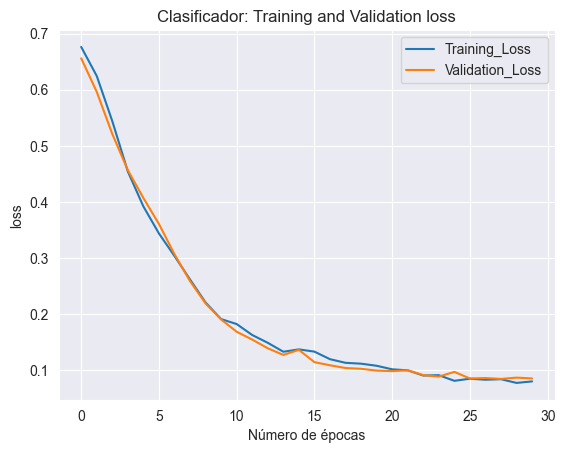

In [41]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

A partir del gráfico de pérdidas que se muestra a continuación, se puede concluir si la pérdida disminuye a medida que aumenta el número de épocas. En esta ocasión, se observa que la caída se va deteniendo a partir de época 10, aproximadamente.

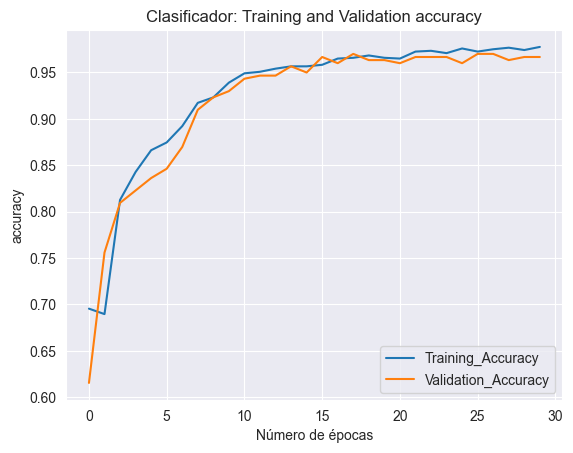

In [42]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

 Se puede observar como la precisión aumenta a lo largo de las épocas. El modelo funciona mejor en los datos de entrenamiento que en los datos de validación.

##  MODELO DE RED LSTM
Las redes LSTM se diseñaron para superar los problemas de las redes neuronales recurrentes (RNN) simples, ya que permite a la red almacenar datos en una especie de memoria a la que puede acceder posteriormente.   


<img src="img/lstm.jpeg">
    
La clave del modelo LSTM es el estado de la celda. El estado de la celda se actualiza dos veces con pocos cálculos que estabilizan los gradientes resultantes. También tiene un estado oculto que actúa como una memoria a corto plazo.      

<img src="img/celdaLSTM.jpg">




En una celda LSTM existen la *PUERTA DE OLVIDO*, la *PUERTA DE ENTRADA* y la *PUERTA DE SALIDA*.

- El primer paso es decidir qué información vamos a desechar del estado de la celda. Esta decisión la toma una capa *sigmoide* llamada capa **"Forget Gate"** (Puerta de olvido).
- El segundo paso consiste en decidir qué información nueva vamos a almacenar en el estado de la celda. Esto se realiza en dos partes:
     1. En primer lugar, una capa *sigmoide* llamada capa **"Input Gate"** (Puerta de entrada) decide qué valores vamos a actualizar. 
     2. A continuación, disponemos de una capa *tanh* que crea un vector de nuevos valores candidatos que podrían añadirse al estado.
 - Por último, se debe decidir cuál será la salida. Esta salida se basará en el estado de nuestra celda, pero será una versión filtrada. 
     1. En primer lugar, se ejecuta una capa *sigmoide* que decide qué partes del estado de la celda se van a emitir. 
     2. A continuación, se pone el estado de la celda, a través de una capa *tanh* (para conseguir que los valores estén entre -1 y 1) y se multiplican por la salida de la puerta *sigmoide*, de modo que sólo se da salida a las partes que se han seleccionado.

### Construcción de la arquitectura del modelo de Red LSTM   

A continuación, ajustamos el modelo de detección de spam utilizando LSTM. Algunos de los nuevos hiperparámetros utilizados en LSTM son *n_lstm* y *return_sequences*.

- **n_lstm = 20** es el número de nodos en las capas ocultas dentro de la celda LSTM
- **return_sequences=True** asegura que la celda LSTM devuelve todas las salidas de la celda LSTM *'desplegada'* a través del tiempo. Si no se utiliza este argumento, la celda LSTM simplemente proporcionará la salida de la celda LSTM del paso anterior.

In [43]:
# Definición de parámetros
n_lstm = 128
drop_lstm = 0.2
# Arquitectura del modelo LSTM  
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 16)         │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,301 (98.84 KB)

 Trainable params: 8,433 (32.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,868 (65.89 KB)

#### Compilación del modelo LSTM

In [45]:
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

### Entrenamiento

El entrenamiento y la evaluación son los mismos que para el modelo de clasificador Dense usado anteriormente.

In [47]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
38/38 - 4s - 102ms/step - accuracy: 0.6410 - loss: 0.6109 - val_accuracy: 0.8294 - val_loss: 0.4239
Epoch 2/30
38/38 - 1s - 23ms/step - accuracy: 0.8778 - loss: 0.3295 - val_accuracy: 0.8963 - val_loss: 0.3167
Epoch 3/30
38/38 - 1s - 24ms/step - accuracy: 0.9397 - loss: 0.1924 - val_accuracy: 0.9565 - val_loss: 0.1572
Epoch 4/30
38/38 - 1s - 22ms/step - accuracy: 0.9548 - loss: 0.1343 - val_accuracy: 0.9498 - val_loss: 0.1245
Epoch 5/30
38/38 - 1s - 22ms/step - accuracy: 0.9523 - loss: 0.1509 - val_accuracy: 0.9632 - val_loss: 0.1540
Epoch 6/30
38/38 - 1s - 22ms/step - accuracy: 0.9523 - loss: 0.1371 - val_accuracy: 0.9465 - val_loss: 0.1740


### Evaluación del modelo. Graficado de pérdidas y precisión.

In [82]:
model1.evaluate(testing_padded, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9525 - loss: 0.1752


[0.1739865094423294, 0.9464883208274841]

El modelo arroja los siguientes datos:   

 - pérdida en TRAIN: 0,1752, 
 - precisión en TRAIN: 95,25%,
 - pérdida en VALIDACIÓN: 0,1739 
 - precisión en VALIDACIÓN: 94,64%.

In [51]:
# Emplazamos las métricas en un DataFrame 
metrics = pd.DataFrame(history.history)
# Cambiamos el nombre de las columnas
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM: Training and Validation ' + string)
    plt.xlabel ('Número de épocas')
    plt.ylabel(string)
    plt.legend([var1, var2])

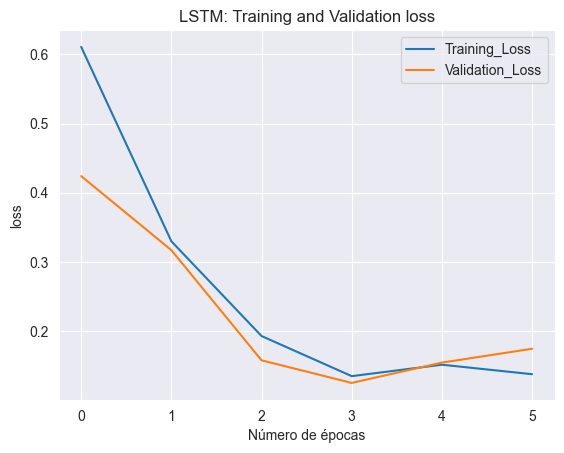

In [52]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

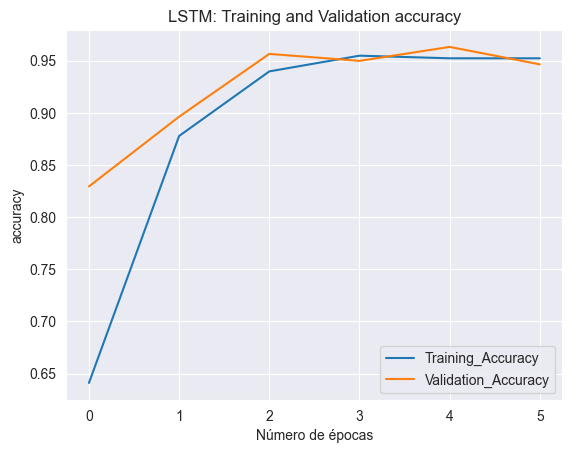

In [53]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Bi-LSTM - LSTM Bidireccional

Una LSTM bidireccional, o Bi-LSTM, es un modelo de procesamiento de secuencias que consta de dos LSTM: una toma la entrada en dirección hacia delante y la otra en dirección hacia atrás. Las Bi-LSTM aumentan la cantidad de información disponible para la red, mejorando el contexto disponible para el algoritmo (por ejemplo, saber qué palabras siguen y preceden inmediatamente a una palabra en una frase). A diferencia de las LSTM estándar, la entrada de Bi-LSTM fluye en ambas direcciones, y es capaz de utilizar la información de ambos lados.   
También es una potente herramienta para modelar las dependencias secuenciales entre palabras y frases en ambas direcciones de la secuencia.

Bi-LSTM añade una capa LSTM más, que invierte la dirección del flujo de información. En pocas palabras, significa que la secuencia de entrada fluye hacia atrás en la capa LSTM adicional. A continuación, se combinan las salidas de ambas capas LSTM de varias formas, como promedio, suma, multiplicación o concatenación.

Para ilustrarlo, en la figura siguiente se presenta la Bi-LSTM desplegada:   


<img src="img/bilstm.jpg">


### Arquitectura del modelo Bi-LSTM

In [65]:
model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))

In [66]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compilación del modelo

In [67]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

### Entrenamiento

In [68]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model2.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30
38/38 - 5s - 133ms/step - accuracy: 0.7314 - loss: 0.5686 - val_accuracy: 0.7592 - val_loss: 0.5075
Epoch 2/30
38/38 - 1s - 37ms/step - accuracy: 0.8745 - loss: 0.3291 - val_accuracy: 0.9398 - val_loss: 0.1882
Epoch 3/30
38/38 - 1s - 37ms/step - accuracy: 0.9506 - loss: 0.1583 - val_accuracy: 0.7993 - val_loss: 0.3862
Epoch 4/30
38/38 - 1s - 36ms/step - accuracy: 0.9531 - loss: 0.1365 - val_accuracy: 0.9666 - val_loss: 0.0958
Epoch 5/30
38/38 - 1s - 36ms/step - accuracy: 0.9632 - loss: 0.1109 - val_accuracy: 0.9666 - val_loss: 0.1223
Epoch 6/30
38/38 - 1s - 30ms/step - accuracy: 0.9540 - loss: 0.1287 - val_accuracy: 0.9666 - val_loss: 0.1063


### Evaluación del modelo: graficado de métricas

In [69]:
# Emplazamos las métricas en un DataFrame 
metrics = pd.DataFrame(history.history)
# Cambiamos el nombre de las columnas
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Bi-LSTM: Training and Validation ' + string)
    plt.xlabel ('Número de épocas')
    plt.ylabel(string)
    plt.legend([var1, var2])

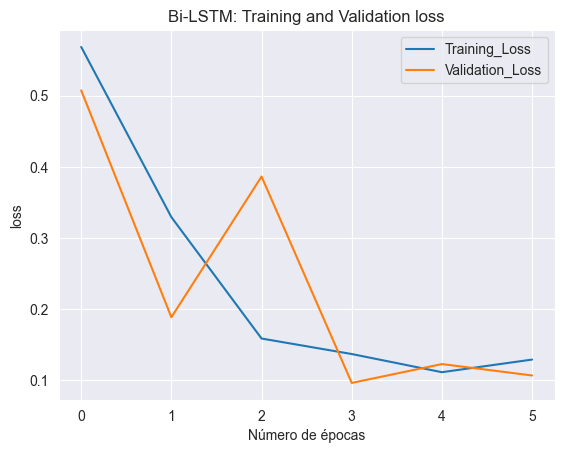

In [70]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

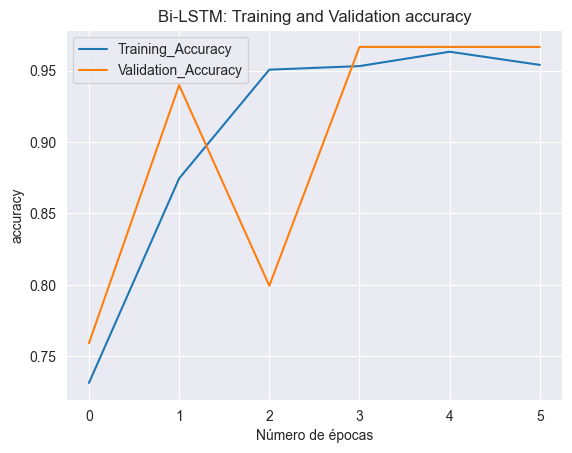

In [71]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Unidad Recurrente Cerrada (GRU - Gated Recurrent Unit)   

Una GRU es un tipo de red neuronal recurrente. Es similar a una LSTM, pero sólo tiene dos puertas: una de reinicio y otra de actualización, y carece de puerta de salida. Al tener menos parámetros, las GRU suelen ser más fáciles y rápidas de entrenar que sus homólogas LSTM.   


<img src="./img/gru.jpg">

### Arquitectura del modelo GRU


In [72]:
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))

In [73]:
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compilación

In [74]:
model3.compile(loss = 'binary_crossentropy',
                       optimizer = 'adam',
                       metrics=['accuracy'])

### Entrenamiento

In [75]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model3.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
38/38 - 5s - 131ms/step - accuracy: 0.5046 - loss: 0.6939 - val_accuracy: 0.4716 - val_loss: 0.6938
Epoch 2/30
38/38 - 1s - 21ms/step - accuracy: 0.4921 - loss: 0.6935 - val_accuracy: 0.4783 - val_loss: 0.6937
Epoch 3/30
38/38 - 1s - 21ms/step - accuracy: 0.5004 - loss: 0.6935 - val_accuracy: 0.5284 - val_loss: 0.6926
Epoch 4/30
38/38 - 1s - 21ms/step - accuracy: 0.4979 - loss: 0.6937 - val_accuracy: 0.4816 - val_loss: 0.6933
Epoch 5/30
38/38 - 1s - 21ms/step - accuracy: 0.5146 - loss: 0.6933 - val_accuracy: 0.4816 - val_loss: 0.6929


### Graficado para la evaluación de métricas

In [77]:
# Emplazamos las métricas en un DataFrame 
metrics = pd.DataFrame(history.history)
# Cambiamos el nombre de las columnas
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('GRU: Training and Validation ' + string)
    plt.xlabel ('Número de épocas')
    plt.ylabel(string)
    plt.legend([var1, var2])

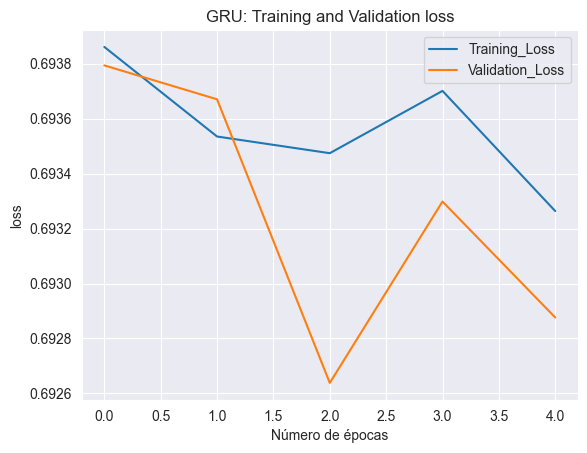

In [78]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

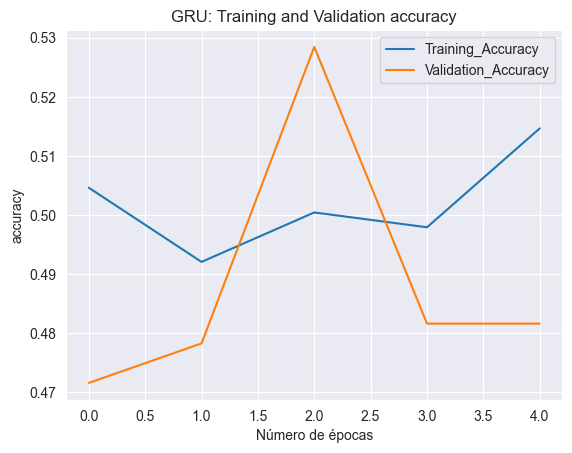

In [79]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Comparativa de los modelos estudiados   

Realizamos la comparativa de los modelos analizados.

In [80]:
# Comparativa de los cuatro modelos analizados
print(f"Dense model loss and accuracy: {model.evaluate(testing_padded, y_test)} " )
print(f"LSTM model loss and accuracy: {model1.evaluate(testing_padded, y_test)} " )
print(f"Bi-LSTM model loss and accuracy: {model2.evaluate(testing_padded, y_test)} " )
print(f"GRU model loss and accuracy: {model3.evaluate(testing_padded, y_test)}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9585 - loss: 0.0915 
Dense model loss and accuracy: [0.08480241149663925, 0.9665551781654358] 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9525 - loss: 0.1752
LSTM model loss and accuracy: [0.1739865094423294, 0.9464883208274841] 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9709 - loss: 0.1092
Bi-LSTM model loss and accuracy: [0.10627947747707367, 0.9665551781654358] 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4416 - loss: 0.6930
GRU model loss and accuracy: [0.692876398563385, 0.4816053509712219]


Basándonos en la pérdida, la precisión y los gráficos, podemos concluir que el modelo *Bi-LSTM* es el mejor modelo para este caso de clasificación, con una precisión de validación = 97,09 % y una pérdida = 0,1092.

## PREDICCIÓN DEL TIPO DE MENSAJE (HAM-SPAM)

Se evalúa la capacidad del modelo Dense sobre como predice/clasifica si se trata de spam o de ham a partir del texto de los datos originales. El primer mensaje es spam, mientras que el segundo es ham.

In [81]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe",
               "Call me"]
def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model.predict(padded))
predict_spam(predict_msg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([[0.9489222],
       [0.0419056]], dtype=float32)

Como se puede comprobar, el modelo predice correctamente la primera frase como SPAM y la segunda como no spam o HAM. Hay cerca de un 95% de probabilidades de que la primera frase sea SPAM.

### Predicción usando el modelo Bi-LSTM

In [83]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe",
               "Call me"]
def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model2.predict(padded))
predict_spam(predict_msg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


array([[0.8598707 ],
       [0.24311107]], dtype=float32)

Al igual que con el modelo anterior, tambien el modelo Bi-LSTM predice correctamente la primera frase como SPAM y la segunda como no spam o HAM. Según este modelo, existe cerca de un 86 % de probabilidades de que la primera frase sea SPAM.